In [119]:
import csv
import sc2reader
import matplotlib.pyplot as plt
import numpy as np
from textwrap import wrap
from itertools import groupby
import scipy.stats as stats

In [28]:
with open("scouting_stats.csv", 'r') as my_csv:
        reader = csv.DictReader(my_csv)
        rows = [r for r in reader]

In [29]:
rows[0].keys()

dict_keys(['GameID', 'UID', 'Rank', 'RelRank', 'ScoutingFrequency', 'RelScoutingFrequency', 'APS', 'RelAPS', 'CPS', 'RelCPS', 'PeaceRate', 'RelPeaceRate', 'BattleRate', 'RelBattleRate', 'Win'])

In [101]:
def make_boxplot(series, categories, ylabel, filename, ylims=None, yscale="linear", markers=None):
    assert len(series) == len(categories), \
        "Each series must have a category label (provided {} series and {} categories)".format(len(series), len(categories))
    plt.clf()
    fig, ax = plt.subplots(figsize=(4 * len(series), 8))

    for i, s in enumerate(series, 1):
        x = np.random.normal(i, 0.04, size=len(s))
        if markers:
            for mark, mask in markers.items():
                plt.plot(np.array(x)[mask], np.array(s)[mask], mark, alpha=0.2)
        else:
            plt.plot(x, s, 'r.', alpha=0.2)
    
    bp = plt.boxplot(series, sym='b+')
    # bp['boxes'][0].set_facecolor(colors[0])
    # bp['boxes'][1].set_facecolor(colors[1])
    plt.setp(bp['medians'], color='black', linewidth='2.5')

    ax.set_yscale(yscale)
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
    # plt.legend((bp['boxes'][0], bp['boxes'][1]), categories)

    # plt.tick_params(
    #     axis='x',  # changes apply to the x-axis
    #     which='both',  # both major and minor ticks are affected
    #     bottom='off',  # ticks along the bottom edge are off
    #     top='off',  # ticks along the top edge are off
    #     labelbottom='off')  # labels along the bottom edge are off
    plt.setp(ax, xticklabels=categories)
    if ylims:
        plt.ylim(*ylims)
    plt.ylabel("\n".join(wrap(ylabel, 60)))
    plt.tight_layout()
    plt.show()
    plt.close()

<Figure size 432x288 with 0 Axes>

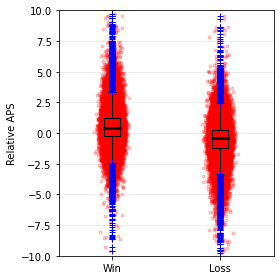

In [31]:
make_boxplot([[float(r["RelAPS"]) for r in rows if r["Win"] == "1"], [float(r["RelAPS"]) for r in rows if r["Win"] == "0"]],
                 ["Win", "Loss"], "Relative APS", "Rel_APS_WL.png", (-10, 10))

In [106]:
def win_rate_plot(field, transform_fn, hist_bins, xlabel):
    binned_pos = [a for a in sorted({transform_fn(r[field]) for r in rows}) if a >= 0]
    vals_to_rows = {val: list(rs) for val, rs in groupby(sorted(rows, key=lambda r: transform_fn(r[field])), lambda r: transform_fn(r[field]))}

    fig, ax = plt.subplots(figsize=(20,10))
    # plot those apm values where we have at least 10 data points to reduce noise
    ax.plot([val for val in binned_pos if len(vals_to_rows[val]) > 10],
            [len([r for r in vals_to_rows[val] if r["Win"] == "1"]) / len(vals_to_rows[val]) for val in binned_pos if len(vals_to_rows[val]) > 10])
    vals = [val for val, r in vals_to_rows.items() for _ in r if val >= 0 and len(r) > 10]
    ax.hist(vals, bins=hist_bins, weights=np.ones_like(vals) / len(vals))
    plt.xlabel(xlabel)
    plt.ylabel("Win Percentage")
    fig.tight_layout()
    plt.show()
    plt.close()

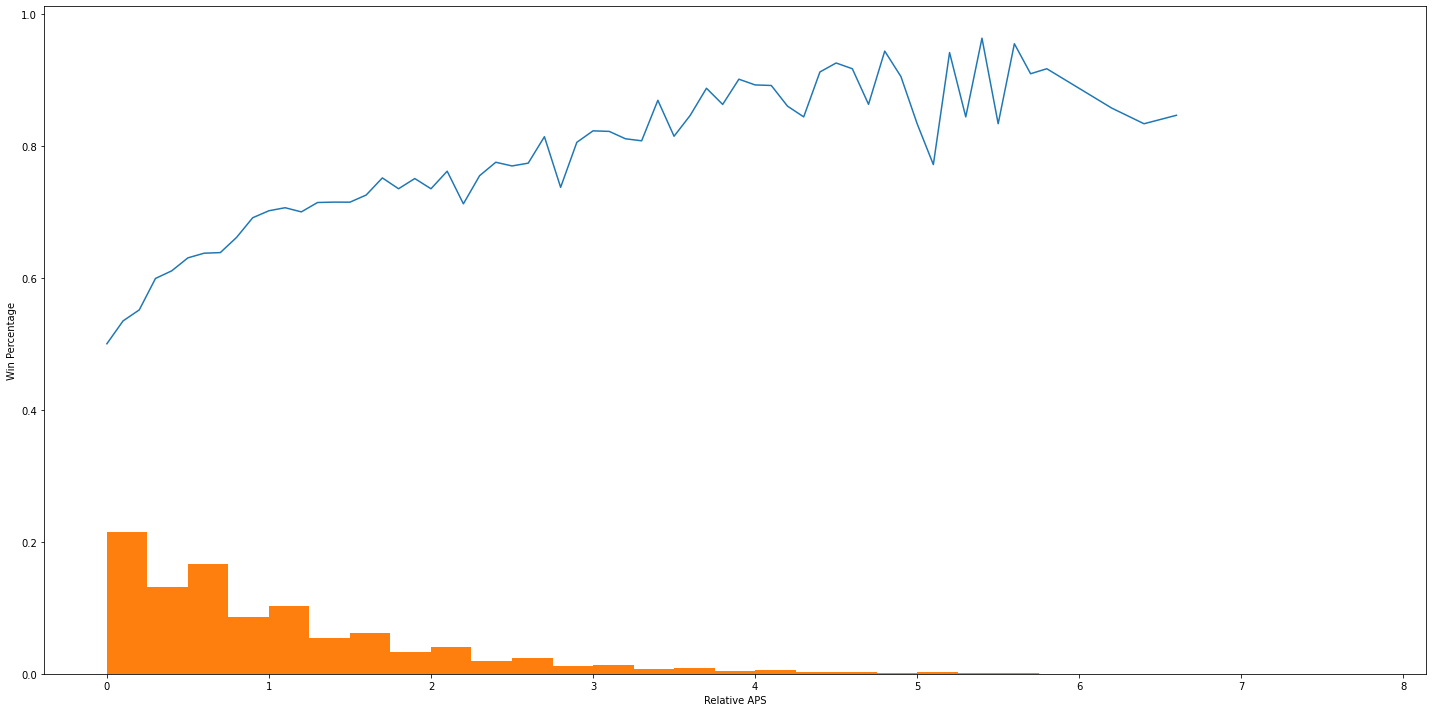

In [107]:
win_rate_plot("RelAPS", lambda x: round(float(x), 1), np.arange(0, 8, 0.25), "Relative APS")

<Figure size 432x288 with 0 Axes>

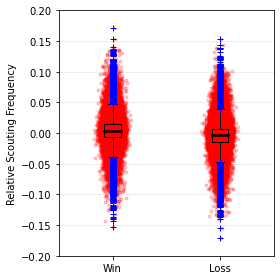

In [40]:
make_boxplot([[float(r["RelScoutingFrequency"]) for r in rows if r["Win"] == "1"], [float(r["RelScoutingFrequency"]) for r in rows if r["Win"] == "0"]],
                 ["Win", "Loss"], "Relative Scouting Frequency", "", (-0.2, 0.2))

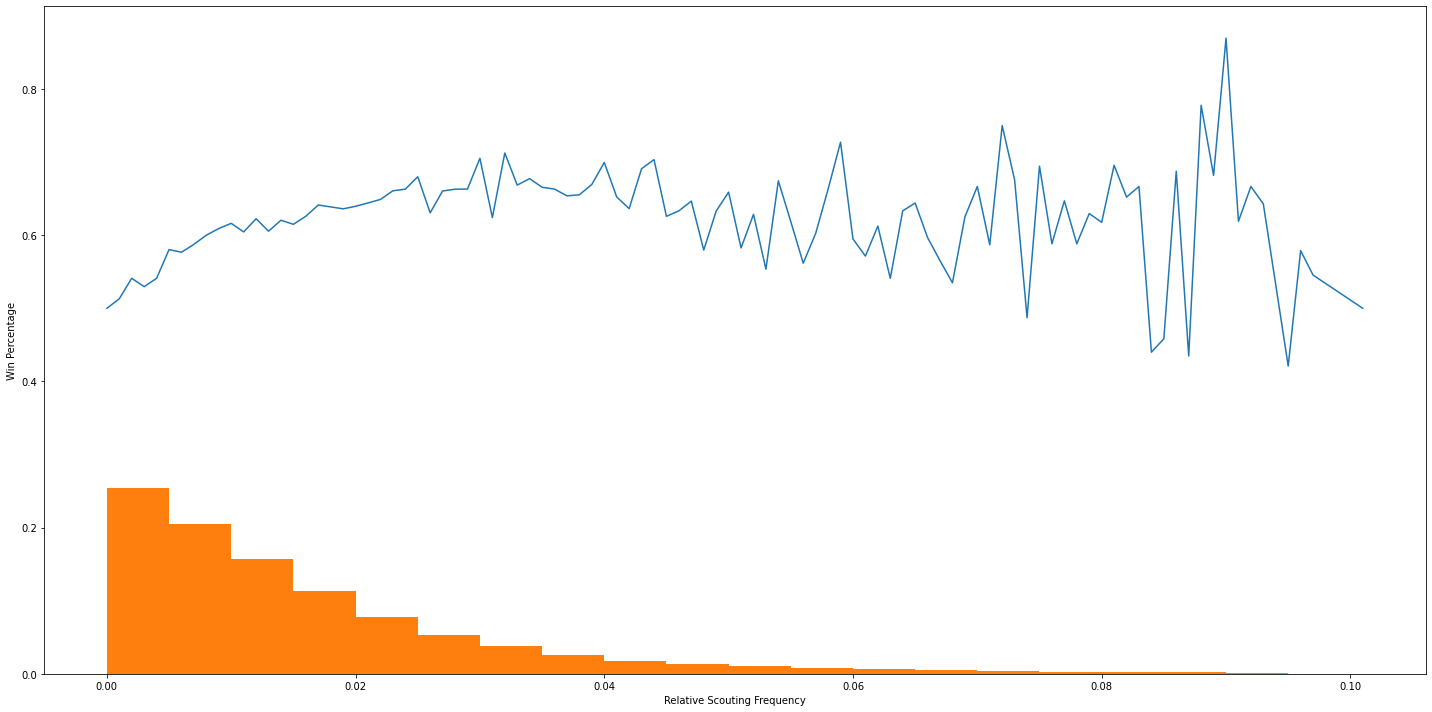

In [108]:
win_rate_plot("RelScoutingFrequency", lambda x: round(float(x), 3), np.arange(0, 0.1, 0.005), "Relative Scouting Frequency")

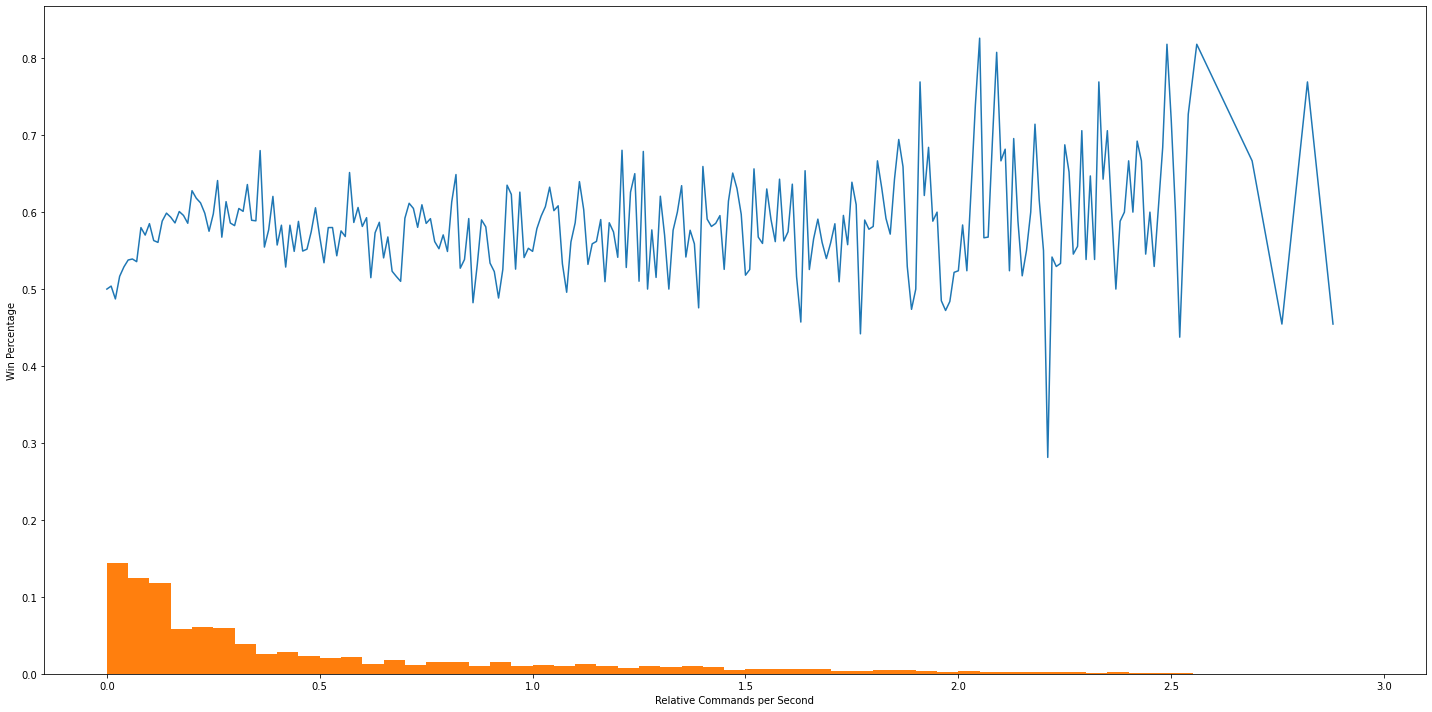

In [109]:
win_rate_plot("RelCPS", lambda x: round(float(x), 2), np.arange(0, 3, 0.05), "Relative Commands per Second")

(array([2.0000e+00, 7.0000e+00, 4.9000e+01, 2.1700e+02, 1.2660e+03,
        1.1846e+04, 4.8382e+04, 1.1846e+04, 1.2660e+03, 2.1700e+02,
        4.9000e+01, 9.0000e+00]),
 array([-6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6]),
 <BarContainer object of 12 artists>)

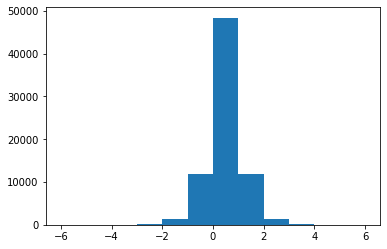

In [104]:
plt.hist([int(r["RelRank"]) for r in rows if r["RelRank"] != "nan"], bins=np.arange(-6, 7))

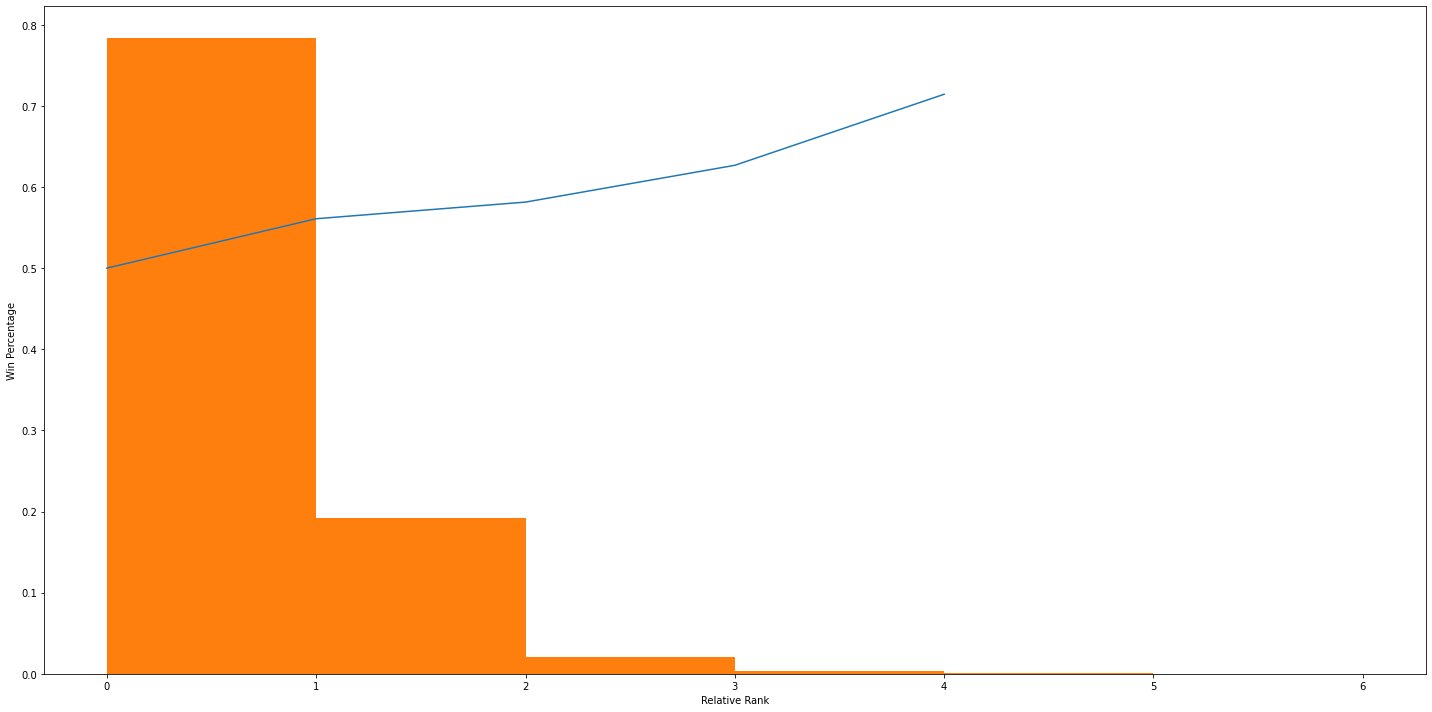

In [110]:
win_rate_plot("RelRank", lambda x: int(x) if x != "nan" else -1, np.arange(0, 7, 1), "Relative Rank")

SpearmanrResult(correlation=0.6998235079873869, pvalue=0.0)


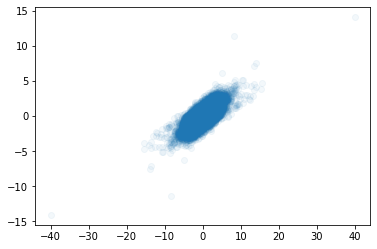

In [129]:
print(stats.spearmanr([float(r["RelAPS"]) for r in rows], [float(r["RelCPS"]) for r in rows]))
plt.scatter([float(r["RelAPS"]) for r in rows], [float(r["RelCPS"]) for r in rows], alpha=0.05)

SpearmanrResult(correlation=0.2253315881653598, pvalue=0.0)


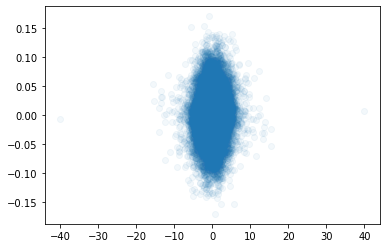

In [127]:
print(stats.spearmanr([float(r["RelAPS"]) for r in rows], [float(r["RelScoutingFrequency"]) for r in rows]))
plt.scatter([float(r["RelAPS"]) for r in rows], [float(r["RelScoutingFrequency"]) for r in rows], alpha=0.05)

SpearmanrResult(correlation=0.5638891020199416, pvalue=0.0)


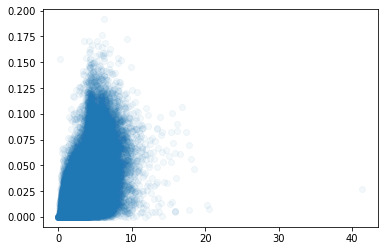

In [128]:
print(stats.spearmanr([float(r["APS"]) for r in rows], [float(r["ScoutingFrequency"]) for r in rows]))
plt.scatter([float(r["APS"]) for r in rows], [float(r["ScoutingFrequency"]) for r in rows], alpha=0.05)